# E-mail network analysis

## Mail Graph creation

### Importing the necessary packages
First of all we begin by importing the necessary packages. The necessary ones are `networkx` and `matplotlib.pyplot`. The first is used for network analysis and the second for plotting.

In [20]:
import networkx as nx  # Core network analysis package
import numpy as np  # Core numeric package
import matplotlib.pyplot as plt  # Core plotting package
import dzcnapy_plotlib as dzcnapy  # Optional library containing pre-made plotting options
import csv  # Package for csv I/O
from collections import Counter  # Import only the single object Counter
import warnings  # To suppress some warnings
#import powerlaw  # To test the power law distribution

#from scipy.optimize import curve_fit

### Reading data files
We open the data in csv format (list of edges representing mail communication) and create the corresponding **directed** graph, called `mail_DG`

In [2]:
with open("email-Eu-core.csv") as infile:
    csv_reader = csv.reader(infile)
    mail_DG = nx.DiGraph(csv_reader)

#print(DG.nodes(data = True))
#print(DG.edges(data = True))

Then we read the second file, which contains the department to which every node belongs, and add the information to the nodes in the graph. The result is a _directed graph_ with an attribute called `department` (with int values from 0 to 41) for each node.
There are 1005 nodes - or people - divided into 42 classes (or departments).

In [3]:
# We create a dictionary of dictionaries, having as key the node label (number between 0 and 1004)
# and with value a dictionary with the name of the attribute ('deprtment') as key and as associated value
# the department number of the node.
# NOTE: this structure is necessary because there could be more attributes, and it is required by the function
# set_node_attributes in networkx

with open("email-Eu-core-department-labels.csv") as infile:
    csv_reader = csv.reader(infile)
    attr_dict_dict = {rows[0]: {'department': int(rows[1])} for rows in csv_reader}

#print(attr_dict_dict)

In [4]:
nx.set_node_attributes(mail_DG, attr_dict_dict)

#print(DG.nodes(data = True))

###### Cleaning the graph
Let us remove the self-loops from the graph (sinche those represent the mail to one-self, irrelevant to the analysis):

In [5]:
self_loops = mail_DG.selfloop_edges()
mail_DG.remove_edges_from(self_loops)

We also create an undirected version of the graph, which might be useful for some manipulation. Note that even if the network is originally undirected, it is not necessarily true that the undirected version has no meaning.
This transposition requires a simple casting.

In [6]:
mail_G = mail_DG.to_undirected()  # Undirected version of graph used for the computation of clustering coefficient

We can see the difference in edges and degree between the original directed graph and its undirected view.

In [7]:
print("DIRECTED VERSION OF THE GRAPH:")
print(nx.info(mail_DG) + "\n")

print("UNDIRECTED VERSION:")
print(nx.info(mail_G))

DIRECTED VERSION OF THE GRAPH:
Name: 
Type: DiGraph
Number of nodes: 1005
Number of edges: 24929
Average in degree:  24.8050
Average out degree:  24.8050

UNDIRECTED VERSION:
Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16064
Average degree:  31.9682


## Department graph creation
The analysis of the department graph (based on the interactions between their elements) could be of interest.
We create the graph by adding all departments as nodes, and then adding edges between them based on the number of (undirected) edges between their elements.

In [8]:
# Graph initialization with just the departments as nodes

dep_G = nx.Graph()
for node in mail_DG.nodes(data = True):
    label, attr_dict = node
    dep_G.add_node(attr_dict["department"])
    
#print(nx.info(dep_G))

In [9]:
# For each edge in the undirected mail graph, identify the department of bot source and target
# and create an edge between those departments in the departments graph if not already existing.
# Otherwise add a weight unit to the existing edge between departments.
for edge in mail_G.edges(data=True):
    source, target, edg_attr = edge
    source_dep = attr_dict_dict[source]['department']
    targ_dep = attr_dict_dict[target]['department']
    if dep_G.has_edge(source_dep, targ_dep) == False:
        dep_G.add_edge(source_dep, targ_dep, weight = 1)
    else:
        edges = dep_G.edges
        w = edges[source_dep, targ_dep]['weight']
        dep_G.add_edge(source_dep, targ_dep, weight = w+1)

Note that the result is an undirected weighted graph with 42 nodes:

In [10]:
print(nx.info(dep_G))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 679
Average degree:  32.3333


### Graph export
To visualize the graphs, we export them in `graphml` format to import them in _Gephi_.

In [11]:
nx.write_graphml(mail_DG, "emails_w_attr_dep.graphml")
nx.write_graphml(dep_G, "departments_weighted.graphml")

## Networks Analysis

### Connected components and Giant Component
#### Mail network
First, we analyze the composition of the network by searching for the weakly and strongly connected components in the directed mail graph.
Note that, clearly, the number of weakly connected components of the directed mail graph is the same as the number of connected components of the undirected mail graph.

In [12]:
n_weak_conn_comp = nx.number_weakly_connected_components(mail_DG)
n_strong_conn_comp = nx.number_strongly_connected_components(mail_DG)
n_conn_comp = nx.number_connected_components(mail_G)

print("# of connected components (undirected version of the graph): " + str(n_conn_comp))
print("# of weakly connected components:                            " + str(n_weak_conn_comp))
print("# of strongly connected components:                          " + str(n_strong_conn_comp))

# of connected components (undirected version of the graph): 20
# of weakly connected components:                            20
# of strongly connected components:                          203


Is there a giant component in the graph?
First we check the undirected graph (which has only {{n_conn_comp}} components)

In [14]:
# Create the list of UNDIRECTED connected components (subgraphs)
connected_components_generator = (mail_G.subgraph(c) for c in nx.connected_components(mail_G))
conn_comp_list = list(connected_components_generator)

# Compute total size and order to see the proportion in the components
tot_nodes_n = mail_G.order()
tot_undirected_edges_n = mail_G.size()

# Initialize variables to search for the biggest component:
max_order = 0
max_order_index = 0  # Initialization for the variable which will contain the position of the component with highest order

HEAD_INDEX = 2  # For printing purposes - Constant
tail_index = len(conn_comp_list) - 1  # For printing purposes - to be adapted 

# Scan through components, find the one with max order and print some info for the first bunch
for (i, component) in zip(range(len(conn_comp_list)), conn_comp_list):
    n_nodes_comp = component.order()
    n_directed_edges_comp = component.size()   
    
    if n_nodes_comp > max_order:
        max_order = n_nodes_comp
        max_order_index = i
    
    relative_order = n_nodes_comp/tot_nodes_n
    relative_size = n_directed_edges_comp/tot_undirected_edges_n
    
    if i <= HEAD_INDEX or i >= tail_index:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print()
    if i == HEAD_INDEX:
        print("...\n")

COMPONENT #0:
# of nodes: 986
# of edges: 16064
Relative Order (proportion of nodes): 0.981094527363184
Relative Size (proportion of edges): 1.0

COMPONENT #1:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

COMPONENT #2:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

...

COMPONENT #19:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0



Yes.
The other 19 components are actually isolated nodes that communicate at most with themselves (self-loops).
Then we hope to find also a strongly connected giant component in the directed graph (which has {{n_strong_conn_comp}} components):

In [15]:
# Create the list of components (subgraphs)
strongly_connected_components_generator = (mail_DG.subgraph(c) for c in nx.strongly_connected_components(mail_DG))
str_conn_comp_list = list(strongly_connected_components_generator)

# Compute total size and order to see the proportion in the components
tot_nodes_n = mail_DG.order()
tot_directed_edges_n = mail_DG.size()

# Initialize variables to search for the biggest component:
max_directed_order = 0
max_directed_order_index = 0

HEAD_INDEX = 1  # For printing purposes - Constant
tail_index = len(str_conn_comp_list) - 1  # For printing purposes - to be adapted 

# Scan through components, find the one with max order and print some info for the first bunch
for (i, component) in zip(range(len(str_conn_comp_list)), str_conn_comp_list):
    n_nodes_comp = component.order()
    n_directed_edges_comp = component.size()   
    
    if n_nodes_comp > max_directed_order:
        max_directed_order = n_nodes_comp
        max_directed_order_index = i
    
    relative_order = n_nodes_comp/tot_nodes_n
    relative_size = n_directed_edges_comp/tot_directed_edges_n
    
    if i <= HEAD_INDEX or i >= tail_index:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print()
    if i == HEAD_INDEX:
        print("...\n")
    if n_nodes_comp > 1:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print("...\n")

COMPONENT #0:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

COMPONENT #1:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

...

COMPONENT #162:
# of nodes: 803
# of edges: 24138
Relative Order (proportion of nodes): 0.7990049751243781
Relative Size (proportion of edges): 0.9682698864775964
...

COMPONENT #202:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0



In this case, too, we gladly find that there is a single giant strongly connected component with {{max_directed_order}} nodes, while the other {{n_strong_conn_comp-1}} components are just single nodes.

In [16]:
# Saving the giant components (both directed and undirected) with simple variable names
giant_component_mail_G = conn_comp_list[max_order_index]
gc_mail_G = giant_component_mail_G

strong_giant_component_mail_DG = str_conn_comp_list[max_directed_order_index]
sgc_mail_DG = strong_giant_component_mail_DG

For the analysis of the mail network, we can in some instances use just the giant component. This will enable us to find measures like distances without risking to find infinite-length (not connected) paths.

### Measures - degree

We first extrapolate the degree of all nodes in the original directed graph, we find the max, we compute the frequency for each degree..

In [31]:
node_and_degrees = mail_DG.degree  # Iterator over 2-tuples (node, degree)

node_degrees = list(deg for _, deg in mail_DG.degree)  # List of degrees

In [37]:
deg_counter = Counter(node_degrees)

degrees = np.array(sorted(deg_counter.keys()))
deg_freq = np.array(list(deg_counter[deg] for deg in degrees))

max_degree = max(degrees)
print("Max degree: " + str(max_degree))

mask_not_null = np.all([degrees != 0, deg_freq != 0], axis = 0)
log_degrees = np.log(degrees[mask_not_null])
log_deg_freq = np.log(deg_freq[mask_not_null])

Max degree: 544


..and then we plot the distribution.

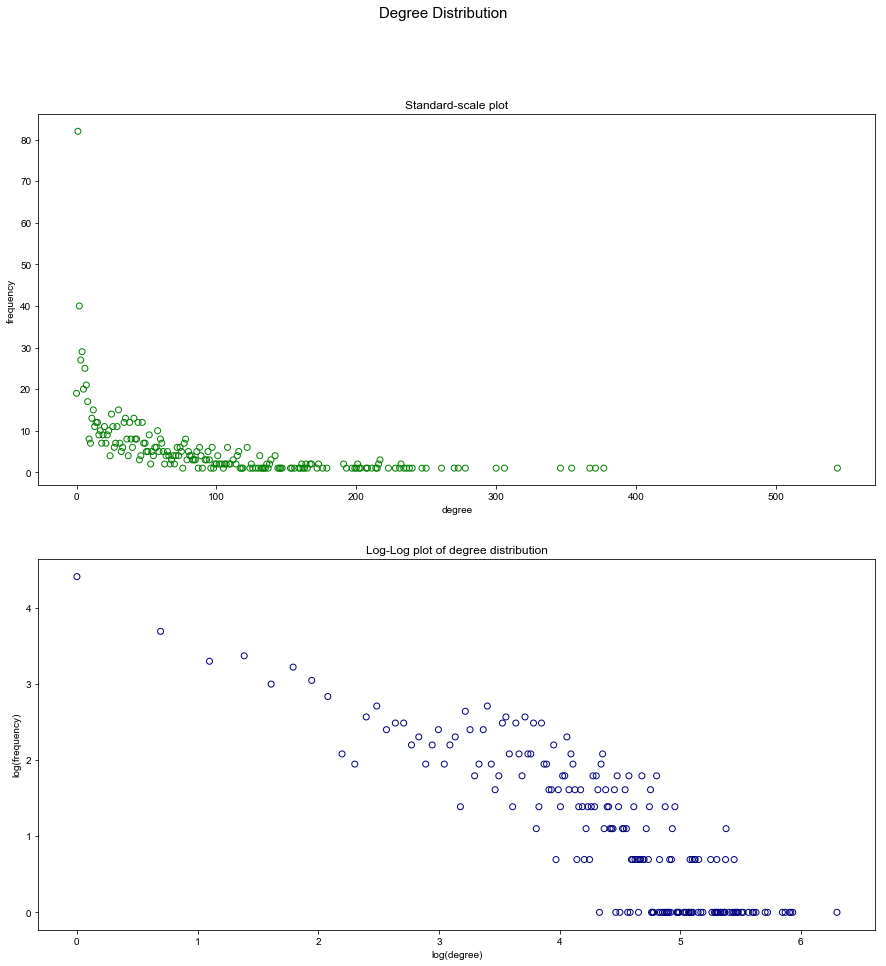

In [38]:
# Create a Figure divided in two Axes (subplots)
fig, (ax, ax_log) = plt.subplots(2, 1)
fig.set_size_inches(15, 15)
fig.suptitle("Degree Distribution", fontsize = 15)

# In the first Axis draw the standard-scale distribution of degrees
ax.set_xlabel('degree')
ax.set_ylabel('frequency')
ax.set_title("Standard-scale plot")
ax.scatter(degrees, deg_freq, marker = 'o', facecolors='none', edgecolors='#008000', label = 'Degree distribution')
degrees = np.array(degrees)

# In the second Axis draw the log-log distribution of degrees
ax_log.set_xlabel('log(degree)')
ax_log.set_ylabel('log(frequency)')
ax_log.set_title("Log-Log plot of degree distribution")
ax_log.scatter(log_degrees, log_deg_freq, marker = 'o', facecolors='none', edgecolors='#000080', label = 'log-log distribution')

# Save the figure as png and plot it
#legend()  # No need for the legend
plt.savefig("degree_distribution.png")
plt.show()

We note that the distribution of the degrees in the whole graph roughly follows a power-law.
If we decided to only consider the degrees of nodes included in the giant strongly connected component, we would find that it probably wouldn't follow a power-law.

Computing the average degree we get the sum of average in-degree and average out-degree, as expected.

In [39]:
tot_deg = sum(deg_freq)

partial_sum = 0
for deg, freq in zip(degrees, deg_freq):
    partial_sum += deg*freq

avg_deg = partial_sum/tot_deg
print("Average degree: " + str(avg_deg))

Average degree: 49.6099502488


In [40]:
partial_sum = 0
for deg, freq in zip(degrees, deg_freq):
    partial_sum += freq*((deg - avg_deg)**2)

var_deg = partial_sum/tot_deg
print("Variance of degree distribution: " + str(var_deg))
print("Standard deviation: " + str(np.sqrt(var_deg)))

Variance of degree distribution: 3570.01104527
Standard deviation: 59.7495694149


The degree distribution seems to satisfy a power-law, hence we can say that the network is scale-free.

### Measures - distances

We compute the distribution of the distances and relevant statistics. For that we use the giant strongly connected component.

In [44]:
nodes = sgc_mail_DG.nodes()

distances = []
for node in nodes:
    distances = distances + list((nx.shortest_path_length(sgc_mail_DG, source = node)).values())

distances = np.array(distances)
dist_freq = Counter(distances)

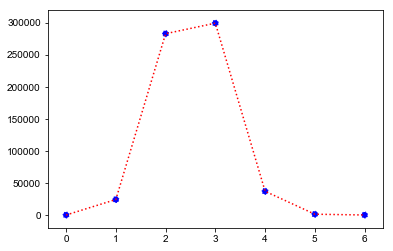

In [45]:
dist_freq_list = list(dist_freq.values())
dist_freq_list[0] = 0  # In the computation of statistics we exclude null distances since they mean nothing

# We do not need to halve the number of distances for a directed graph, since the distances are NOT symmetric

plt.plot(dist_freq_list, linestyle='dotted', color = 'red')
plt.scatter(range(len(dist_freq_list)), dist_freq_list, linestyle='dotted', color = 'blue')
plt.savefig("distance_distribution.png")

In [46]:
# Compute the radius and the diameter:
eccentricities = nx.eccentricity(sgc_mail_DG)
radius = min(eccentricities.values())  # Manual radius
diameter = max(eccentricities.values())  # Manual diameter

# Compute the average distance
partial_sum = 0
for i in range(diameter+1):
    partial_sum += i*dist_freq_list[i]

avg_dist = partial_sum/sum(dist_freq_list)
avg_dist

2.5474824768713336

In [47]:
# DEPRECATED: now they correspond
# Note that the average shortest path computed by the built-in function is DIFFERENT for a directed graph.
# In this case it seems to be due to the funcion dividing by the total number of undirected distances instead
# of the number of directed distances (which are LESS)
nx.average_shortest_path_length(sgc_mail_DG)

2.5474824768713336

In [75]:
eccentricities = nx.eccentricity(sgc_mail_DG)

In [73]:
min(eccentricities.values())  # Manual radius

3

In [74]:
max(eccentricities.values())  # Manual diameter

6

We want to check the clustering coefficient for departments. We create the subgraphs for each department.

In [69]:
def department_clustering(DG):
    
    nodes = DG.nodes(data = True)

    listona = []
    for i in range(42):
        listona.append(DG.subgraph([n for n, attrdict in DG.node.items() if attrdict['department'] == i]))

    avg_clust_dep = np.zeros(42)
    for i in range(42):
        if len(listona[i].nodes()) != 0:
            avg_clust_dep[i] = nx.average_clustering(listona[i].to_undirected())
        else:
            avg_clust_dep[i] = None
    
    return avg_clust_dep

avg_clust_dep = department_clustering(sgc_mail_DG)
for i in range(42):
    print("Avg clustering coefficient for department " + str(i) + ": " + str(avg_clust_dep[i]))

Avg clustering coefficient for department 0: 0.65096676571
Avg clustering coefficient for department 1: 0.690848114654
Avg clustering coefficient for department 2: 0.894047619048
Avg clustering coefficient for department 3: 0.748095238095
Avg clustering coefficient for department 4: 0.496717226017
Avg clustering coefficient for department 5: 0.86339151045
Avg clustering coefficient for department 6: 0.0
Avg clustering coefficient for department 7: 0.804021513974
Avg clustering coefficient for department 8: 0.776966243633
Avg clustering coefficient for department 9: 0.58062004662
Avg clustering coefficient for department 10: 0.754658703203
Avg clustering coefficient for department 11: 0.871136729154
Avg clustering coefficient for department 12: 1.0
Avg clustering coefficient for department 13: 0.825066414045
Avg clustering coefficient for department 14: 0.541140271097
Avg clustering coefficient for department 15: 0.638025045008
Avg clustering coefficient for department 16: 0.87405384347

In [54]:
components = nx.algorithms.community.centrality.girvan_newman(sgc_mail_DG)
for component in components:
    print(component)

({'288', '665', '434', '385', '14', '447', '377', '617', '332', '82', '799', '388', '387', '813', '826', '644', '314', '562', '896', '954', '947', '286', '822', '55', '81', '112', '887', '94', '905', '776', '114', '851', '590', '348', '83', '717', '856', '496', '181', '510', '520', '159', '21', '424', '737', '528', '107', '360', '71', '672', '324', '168', '957', '945', '859', '450', '527', '167', '104', '225', '174', '572', '818', '414', '872', '92', '153', '621', '7', '616', '177', '806', '938', '725', '198', '403', '844', '485', '135', '281', '681', '955', '507', '506', '632', '193', '261', '369', '840', '4', '530', '147', '501', '543', '149', '511', '337', '978', '355', '969', '378', '537', '880', '379', '758', '321', '407', '381', '552', '255', '211', '226', '482', '694', '491', '926', '499', '698', '176', '466', '351', '306', '512', '305', '1003', '40', '299', '495', '526', '103', '610', '131', '8', '812', '127', '179', '525', '313', '395', '303', '243', '241', '87', '455', '697',

({'288', '665', '434', '385', '14', '447', '377', '617', '332', '82', '799', '388', '387', '813', '826', '644', '314', '562', '896', '954', '947', '286', '822', '55', '81', '112', '887', '94', '905', '776', '114', '851', '590', '348', '83', '717', '856', '496', '181', '510', '520', '159', '21', '424', '737', '528', '107', '360', '71', '672', '324', '168', '957', '945', '859', '450', '527', '167', '104', '225', '174', '572', '818', '414', '872', '92', '153', '621', '7', '616', '177', '806', '938', '725', '198', '403', '844', '485', '135', '281', '681', '955', '507', '506', '632', '193', '261', '369', '840', '4', '530', '147', '501', '543', '149', '511', '337', '978', '355', '969', '378', '537', '880', '379', '758', '321', '407', '381', '552', '255', '211', '226', '482', '694', '491', '926', '499', '698', '176', '466', '351', '306', '512', '305', '1003', '40', '299', '495', '526', '103', '610', '131', '8', '812', '127', '179', '525', '313', '395', '303', '243', '241', '87', '455', '697',

KeyboardInterrupt: 

In [ ]:
components = nx.algorithms.community.centrality.girvan_newman(dep_G)

lis = list(components)
for tup in lis:
    print(len(tup))

# END

In [162]:
nodes = mail_G.nodes(data=True)
n_nodes_per_dep = np.zeros(42)
for i, node in zip(range(len(mail_G.nodes(data=True))), mail_G.nodes(data=True)):
    num, dicti = node
    n_nodes_per_dep[dicti['department']] += 1

prob_dep = n_nodes_per_dep/len(mail_G.nodes(data=True))

In [159]:
prob_same_dep = sum(prob_dep**2)
prob_diff_dep = 1-prob_same_dep
prob_diff_dep

0.95238434692210583

In [160]:
diff_dep = 0
for edge in mail_G.edges(data=True):
    source, target, _ = edge
    src_dep = mail_G.nodes[source]['department']
    trg_dep = mail_G.nodes[target]['department']
    if (src_dep is not trg_dep):
        diff_dep += 1
diff_dep/len(mail_G.edges())

0.6642803784860558

In [ ]:
print("density of email network:", str(nx.density(mail_DG)))
print("density of department network:", str(nx.density(dep_G)))

In [133]:
nx.average_clustering(mail_G)

0.3993549664221539

In [132]:
nx.clustering(mail_G)

{'0': 0.2764227642276423,
 '1': 0.2653061224489796,
 '2': 0.2978027115474521,
 '3': 0.38491048593350385,
 '4': 0.31869137497140243,
 '5': 0.10700197238658778,
 '6': 0.15518331226295828,
 '7': 0.28778467908902694,
 '8': 0.4470588235294118,
 '9': 0.42532005689900426,
 '10': 0.3154486586493987,
 '11': 0.22917437985931136,
 '12': 0.3025974025974026,
 '13': 0.11089951120421507,
 '14': 0.21578421578421578,
 '15': 0.3526530612244898,
 '16': 0.28470936690114773,
 '17': 0.28593272171253825,
 '18': 0.30118798043326345,
 '19': 0.28322981366459626,
 '20': 0.28482003129890454,
 '21': 0.24803921568627452,
 '22': 0.38461538461538464,
 '23': 0.3427458617332035,
 '24': 0.38549075391180654,
 '25': 0.48295454545454547,
 '26': 0.5208333333333334,
 '27': 0.36885245901639346,
 '28': 0.34475537787930705,
 '29': 0.3935064935064935,
 '30': 0.4027972027972028,
 '31': 0.4122340425531915,
 '32': 0.5473484848484849,
 '33': 0.5793650793650794,
 '34': 0.6379310344827587,
 '35': 0.41228070175438597,
 '36': 0.46511627

In [ ]:
central_node = 160
CC_dict = nx.clustering(mail_G)
CC = sum(CC_dict.values())/len(CC_dict.values())
print("CC:", CC)

cc_central_node = nx.clustering(G, str(central_node))
betweenness = nx.betweenness_centrality(DG, normalized = False)
print("clustering coefficient:", str(cc_central_node))
print("betweenness of nodes:", str(betweenness))
type(betweenness)

In [ ]:
lis = []
for key in betweenness.keys():
    lis.append(betweenness[key])

plt.plot(range(len(lis)), lis)

In [ ]:
print("betweenness of departments:", str(nx.betweenness_centrality(DG_only_dep, normalized = False)))

In [128]:
lista = nx.degree(mail_DG)
assortativity = np.zeros(len(degrees))
avg_neighbor_deg = nx.average_neighbor_degree(mail_DG, source = 'out', target = 'out')
for i in range(1, len(assortativity)):
    avg = 0
    num = 0
    summ = 0
    for node_str, degree in lista:
        if degree == i:
            num += 1
            summ += avg_neighbor_deg[node_str]
    avg = summ/num if num is not 0 else 0
    assortativity[i] = avg

print(assortativity)

[  0.          11.12195122  35.          26.2962963   21.56896552
  18.72333333  34.78333333  48.12857143  28.07352941  45.178125
  52.55952381  55.91770452  66.42349206  52.17316017  79.41236772
  72.74355159  40.27157102  53.89793651  42.9246337   49.82506614
  53.20561459  44.48339438  54.92257742  55.32309524  57.03940851
  47.97598921  65.15124875  55.501998    61.00549034  51.75617633
  53.23482972  42.22141549  54.45731158  52.96957672  59.98094884
  53.49782644  52.58981377  39.89913844  56.87610301  53.70396983
  52.11658769  51.28374575  66.44263019  56.77952671  57.25926297
  70.84701754  58.50348017  61.38356479  57.02008668  58.70009262
  48.69546654  53.84753114  51.88185599  46.47727273  54.80238785
  72.35312002  57.61020595  71.26904133  53.99821788  65.2547619
  60.40103088  52.68418844  45.13428161  58.64516129  49.67471338
  56.23193738  56.76774686  46.48794643  52.32352941  73.6405017
  54.20363745  49.74108527  63.35074635  50.68729998  57.41900539
  68.51055502 

-0.013708196002


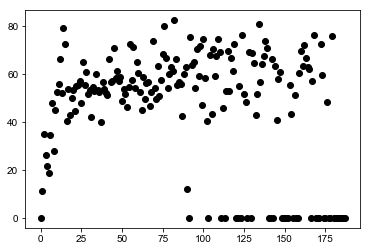

In [129]:
print(nx.degree_assortativity_coefficient(mail_DG))
plt.scatter(range(len(assortativity)), assortativity)